In [60]:
import h5py
import numpy as np
import bisect
import matplotlib.pyplot as plt
import astropy.units as u
from astropy import constants as const
import speclite.filters
from astropy.table import Table, vstack
from astropy.io import ascii
from scipy.interpolate import interp1d
import warnings
warnings.filterwarnings(action='ignore')

In [69]:
def h5py_to_table(path_h5py, dist, t):
	fin    = h5py.File(path_h5py, 'r')
	# frequency in Hz
	nu    = np.array(fin['nu'],dtype='d') * (u.Hz)
	# array of time in seconds
	times = np.array(fin['time'])
	# covert time to days
	times = times/3600.0/24.0
	# specific luminosity (ergs/s/Hz)
	# this is a 2D array, Lnu[times][nu]
	Lnu_all = np.array(fin['Lnu'], dtype='d') * (u.erg / u.second / u.Hz)
		
	# index corresponding to t
	it = bisect.bisect(times, t)
	# print(t, it, times[it])
	# spectrum at this epoch	
	Lnu = Lnu_all[it,:]

	# if you want thing in Flambda (ergs/s/Angstrom)
	# c = 2.99e10 * (u.cm/u.second)
	c = const.c
	lam = c/nu
	Llam = Lnu*(nu*nu)/c

	Llam = Llam.to(u.erg/u.second/u.Angstrom)

	outbl = Table()
	outbl['nu'] = nu
	outbl['Lnu'] = Lnu
	outbl['lam'] = lam.to(u.Angstrom)
	outbl['Llam'] = Llam.to(u.erg/u.second/u.Angstrom)

	return outbl

In [70]:
path_table = f"../3.table"
path_plot = f"../4.plot"
path_kasen = '../3.table/Kasen_Kilonova_Models_2017-master/kilonova_models'

In [71]:
h5py_blue = 'knova_d1_n10_m0.025_vk0.30_Xlan1e-4.0.h5'	#	Blue KN
h5py_red = 'knova_d1_n10_m0.040_vk0.15_Xlan1e-1.5.h5'	#	Red KN
# days = np.linspace(0.025, 3, 15)
days = np.arange(0.05, 2.95+0.10*2, 0.10*2)
distMpc, distMpc_err = 37.7, 8.7
dist = distMpc*u.Mpc
disterr = distMpc_err*u.Mpc

tblist = []
filters = speclite.filters.load_filters('sdss2010-*')
filterlist = ['sdss2010-g', 'sdss2010-r', 'sdss2010-i',]

In [65]:
# fin    = h5py.File(path_kasen+'/'+h5py_blue, 'r')
# # frequency in Hz
# nu    = np.array(fin['nu'],dtype='d') * (u.Hz)
# # array of time in seconds
# times = np.array(fin['time']) * (u.second)
# # times.to(u.day).min(), times.to(u.day).max()
# times.to(u.day)[20:]


In [72]:
# for t in days:
for t in [0.45]:
	bluetbl = h5py_to_table(path_kasen+'/'+h5py_blue, dist, t)
	redtbl = h5py_to_table(path_kasen+'/'+h5py_red, dist, t)

	# lam_com, Llam_com = bluetbl['lam'], (redtbl['Llam']+bluetbl['Llam'])/2
	lam_com, Llam_com = bluetbl['lam'], (redtbl['Llam']+bluetbl['Llam'])
	# lam_com, Llam_com = bluetbl['lam'], bluetbl['Llam']

	# open model file
	# plt.plot(lam_com, Llam_com)
	# plt.ion()

	#    REVERSE INDEX
	indx = np.argsort(lam_com)
	flux = Llam_com[indx]/(4*np.pi*(dist**2))
	flux_upper = Llam_com[indx]/(4*np.pi*((dist+disterr)**2))
	flux_lower = Llam_com[indx]/(4*np.pi*((dist-disterr)**2))
	
	mags = filters.get_ab_magnitudes(flux, lam_com[indx])
	magserr_upper = filters.get_ab_magnitudes(flux_upper, lam_com[indx])
	magserr_lower = filters.get_ab_magnitudes(flux_lower, lam_com[indx])

	for err, errtbl in zip(['upper', 'lower'], [magserr_upper, magserr_lower]):
		for key in errtbl.keys():
			mags['{}_{}'.format(key, err)] = errtbl[key].item()

	mags['t'] = t

	tblist.append(mags)
	# print(mags['sdss2010-r'])
comtbl = vstack(tblist)

for key in comtbl.keys():
	comtbl[key].format = '1.3f'

(3000.0, 9000.0)

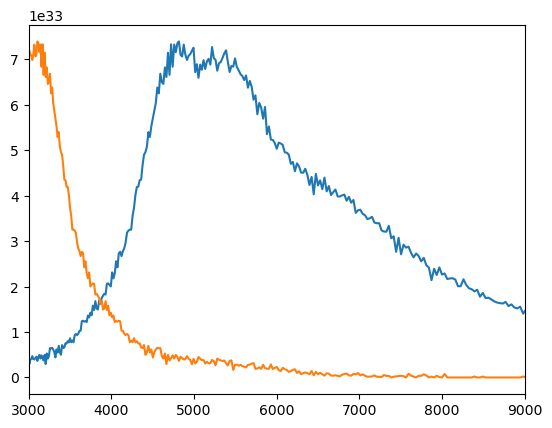

In [87]:
plt.plot(lam_com[indx], flux)
plt.plot(lam_com, flux)

plt.xlim([3000, 9000])


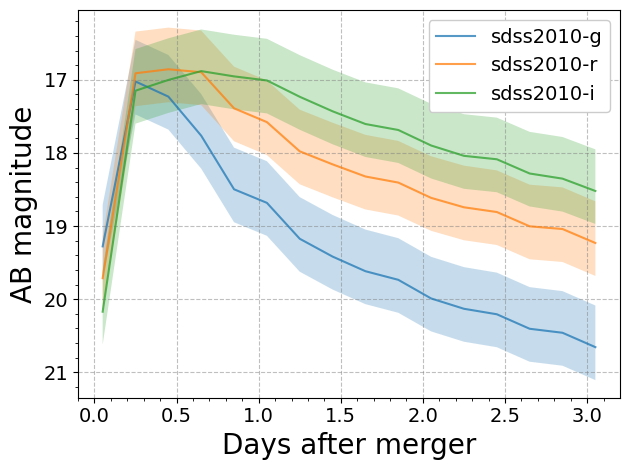

In [68]:
plt.close('all')
for filte in comtbl.keys():
	if filte in filterlist:
		plt.plot(comtbl['t'], comtbl[filte], linestyle='-', alpha=0.75, label=filte)
		plt.fill_between(comtbl['t'], comtbl['{}_lower'.format(filte)], comtbl['{}_upper'.format(filte)], alpha=0.25)
	else:
		pass
#------------------------------------------------------------
tmplist = []
for f in filterlist:
	tmplist.append(f.split('-')[1])
filtername = ''.join(tmplist)

# filehead = 'kasen+17.blue+red.{}+-{}.{}-{}.{}.figure5.comparison'.format(distMpc, distMpc_err, days[0], days[-1], filtername)
# comtbl.write(f'{path_table}/GW190425_GWTC-2_kasen.ecsv', format='ascii.ecsv', overwrite=True)
#------------------------------------------------------------
# plt.scatter(figtbl['deltime'], figtbl['mag'], alpha=0.5, label='Figure 5')
# plt.plot(figtbl['deltime'], figtbl['mag'], alpha=0.5, label='Figure 5')
#------------------------------------------------------------
# drtbl = droutbl[droutbl['filter']=='r']
# plt.errorbar(drtbl['delmjd'], drtbl['mag'], yerr=drtbl['magerr'], label='Drout+17')
#------------------------------------------------------------
down, up = plt.ylim()
plt.ylim(up, down)
plt.legend(fontsize=14, framealpha=1.0)
# plt.title(r'Kilonova at {}$\pm${}Mpc (Kasen+17)'.format(distMpc, distMpc_err), fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Days after merger', fontsize=20)
plt.ylabel('AB magnitude', fontsize=20)
plt.grid('both', linestyle='--', color='grey', alpha=0.5)
plt.tight_layout()
plt.minorticks_on()
# plt.savefig(f'{path_plot}/GW190425_GWTC-2_kasen.png', dpi=200, overwrite=True)